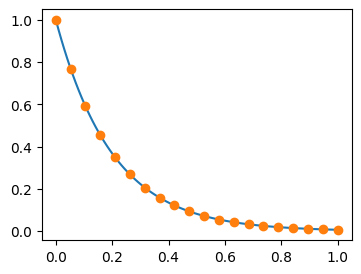

In [1]:
import numpy as np 
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import warnings
from scipy.integrate import odeint

warnings.filterwarnings("ignore")
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the system of ODEs
def model(y, t, k):
    dy1dt = -k * y
    return dy1dt

y0 = 1
T_START = 0
T_END = 1
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k = 5
solution = odeint(model, y0, t, args=(k,))

# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)

# Create true data
t_true = torch.from_numpy(t).float().view(-1,1).to(DEVICE)
y_true = torch.from_numpy(solution).float().to(DEVICE)

# Make training data
n_samples = 20
t_train = torch.linspace(T_START, T_END, n_samples).view(-1,1).requires_grad_(True).to(DEVICE)
y_train = z_1(t_train.cpu().detach().numpy())

# Plot true and training data 
plt.figure(figsize=(4,3))
plt.plot(t_true.cpu().numpy(), y_true.cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_train, 'o')
plt.show()

In [17]:
# Make a NN for u
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 10)
        self.fc3 = nn.Linear(10, 1)
        
        self.k = nn.Parameter(torch.tensor([2.0]))
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)
us_train = torch.tensor(y_train, requires_grad=True).float().to(DEVICE)

In [19]:
def residual(t, model: nn.Module):
    t = torch.linspace(T_START, T_END, 500).view(-1,1).to(DEVICE)
    t.requires_grad = True
    u = model(t).to(DEVICE)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u_t + model.k * u

In [20]:
network = Network().to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 10000
LOSS = []
for epoch in range(EPOCHS):
    
    u_pred = network.forward(ts_train)
    residual_pred = residual(ts_train, network)
    
    loss = criterion(u_pred, us_train)
    loss += torch.mean(residual_pred**2)
    
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}] Loss: {loss}, k: {network.k.item()}')
        

Epoch [0/10000] Loss: 0.15550479292869568, k: 1.9989999532699585
Epoch [500/10000] Loss: 0.024198029190301895, k: 1.7912497520446777
Epoch [1000/10000] Loss: 0.015701258555054665, k: 2.2724599838256836
Epoch [1500/10000] Loss: 0.010091708973050117, k: 2.706796169281006
Epoch [2000/10000] Loss: 0.006548017263412476, k: 3.081120252609253
Epoch [2500/10000] Loss: 0.004276946187019348, k: 3.40730881690979
Epoch [3000/10000] Loss: 0.0027841052506119013, k: 3.691823720932007
Epoch [3500/10000] Loss: 0.0017745696241036057, k: 3.9414918422698975
Epoch [4000/10000] Loss: 0.001068992423824966, k: 4.162558555603027
Epoch [4500/10000] Loss: 0.00060936069348827, k: 4.361053943634033
Epoch [5000/10000] Loss: 0.00028807800845243037, k: 4.538455486297607
Epoch [5500/10000] Loss: 0.0001316207490162924, k: 4.687505722045898
Epoch [6000/10000] Loss: 5.668990343110636e-05, k: 4.802347660064697
Epoch [6500/10000] Loss: 2.4727010895730928e-05, k: 4.883512496948242
Epoch [7000/10000] Loss: 1.271702058147639e

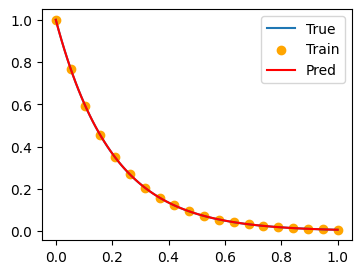

In [7]:
# Plot u_pred vs ts
network.eval()
with torch.no_grad():
    u_pred = network(t_true)
    plt.figure(figsize=(4,3))
    plt.plot(t_true.cpu(), y_true.cpu(), label='True')
    plt.scatter(t_train.cpu(), y_train, label='Train', color='orange')
    plt.plot(t_true.cpu(), u_pred.cpu().numpy(), label='Pred', color='red')
    plt.legend()
    plt.show()

In [13]:
network.k

Parameter containing:
tensor([4.9958], device='cuda:0', requires_grad=True)